#### Volatility in risk management is the standard deviation of the continuously compounded return per day.
#### Several models can be used to measure volatility: EWMA, ARCH, GARCH. This project implement a GARCH(1,1) model.

In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy
import os
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
np.set_printoptions(precision=3)
#without using scientific number in numpy;
np.set_printoptions(suppress=True)
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [36]:
cwd = os.getcwd()
os.chdir("H:\\interest_rate_risk")
warnings.filterwarnings('ignore')
sap01=pd.read_excel("H:\\volatility\\raw_data.ods",engine='odf')

In [37]:
sap01.columns=['date','value']
sap01.shape
sap02=sap01.shift()
sap01['value_last_day']=sap02.value
sap03=sap01.iloc[1:,:]
sap03['return']=sap03.value/sap03.value_last_day-1
sap03.head()

,date,value,value_last_day,return
1,2005-07-19,1229.35,1221.13,0.006731
2,2005-07-20,1235.20,1229.35,0.004759
3,2005-07-21,1227.04,1235.20,-0.006606
4,2005-07-22,1233.68,1227.04,0.005411
5,2005-07-25,1229.03,1233.68,-0.003769


plot first 1000 days of S&P500 daily return starting on July,18,2005;

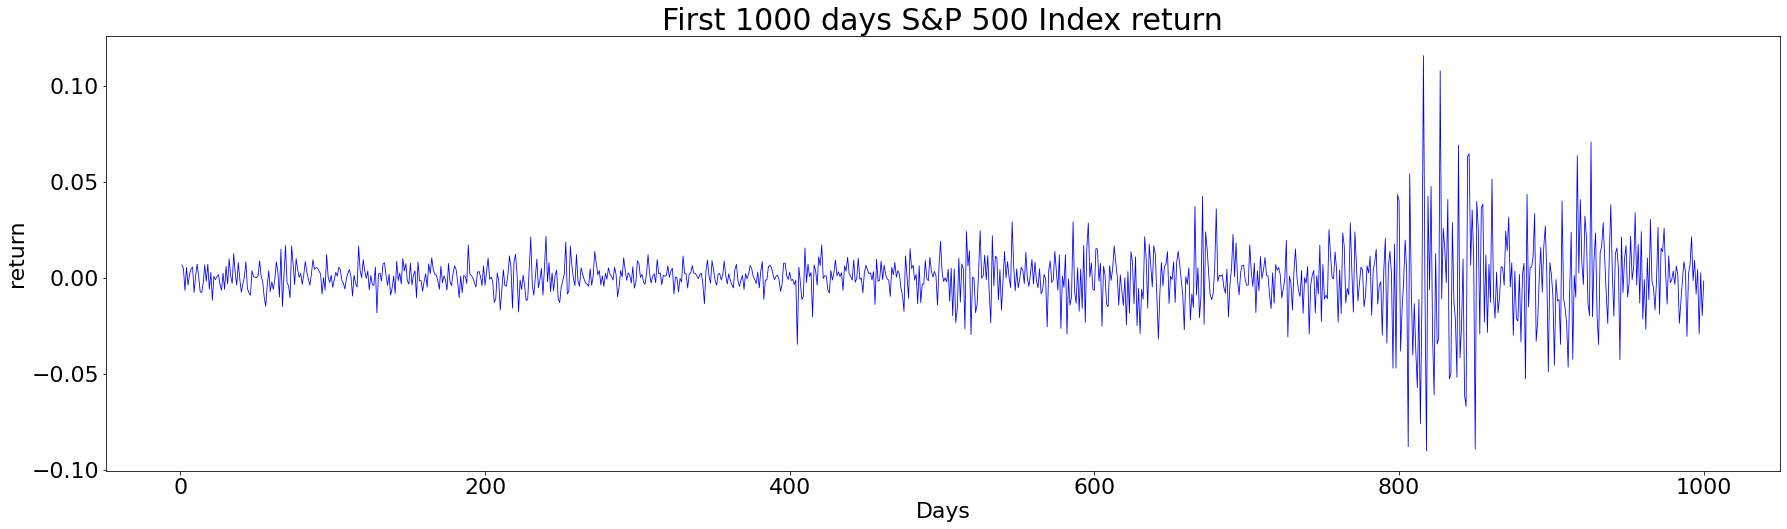

In [39]:
plt.plot([i for i in range(1,1001)], sap03.loc[0:1000,'return'].to_list(),c='blue',linewidth=0.8)

plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel("Days", fontsize=22)
plt.ylabel("return", fontsize=22)
plt.rcParams.update({'font.size': 22})
plt.title('First 1000 days S&P 500 Index return',fontsize=30)
plt.show()
plt.close()

it seems clear that returns are more volatile in some time periods than others and
variance of return isn't constant, especially in later periods, so this return series 
is non-stationary;
we can plot absolute returns to see more clearly;

In [40]:
r_abs=[abs(r) for r in sap03['return'].to_list()]

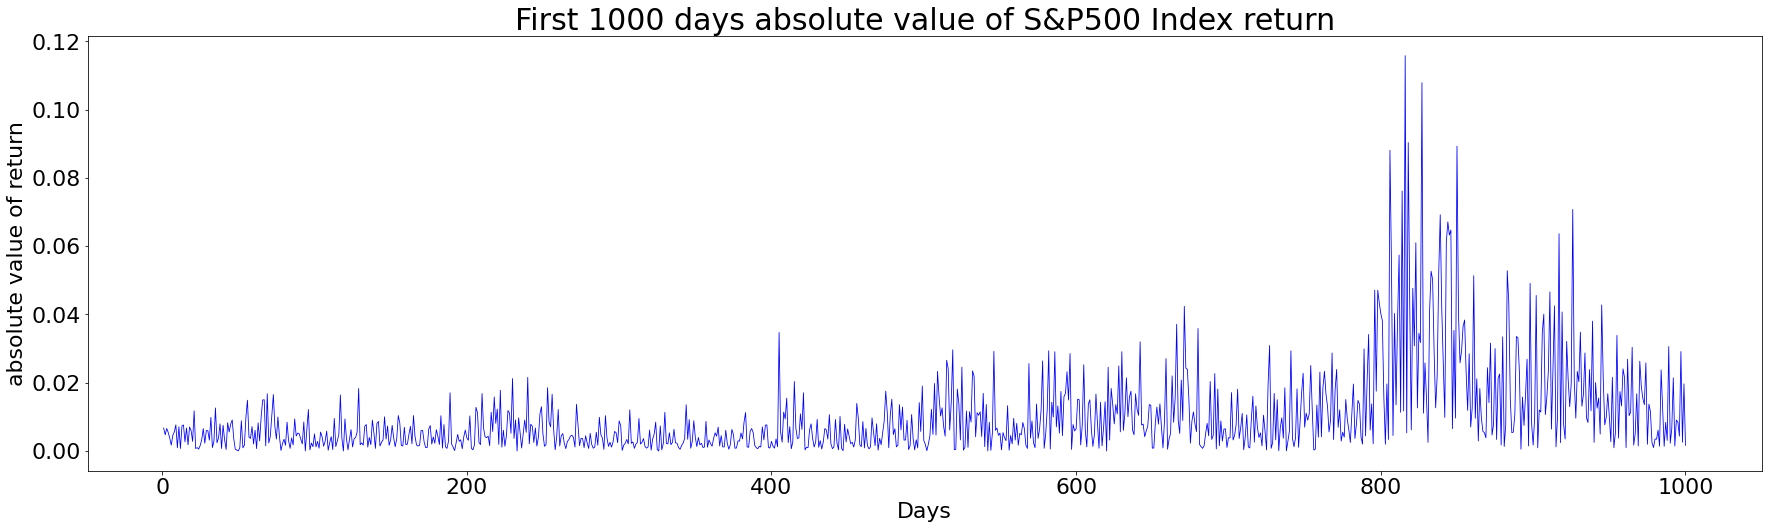

In [41]:
plt.plot([i for i in range(1,1001)], r_abs[0:1000],c='blue',linewidth=0.8)

plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel("Days", fontsize=22)
plt.ylabel("absolute value of return", fontsize=22)
plt.rcParams.update({'font.size': 22})
plt.title('First 1000 days absolute value of S&P500 Index return',fontsize=30)
plt.show()
plt.close()

clearly we see some 'volatility clustering' in the chart; 

in stock return example, the average return $\bar u$ is assumed to be zero, we now test if this is true.

In [42]:
temp_col=sap03['return'].to_list()
print('%f' % ( np.mean(temp_col) ),'%f' % ( np.std(temp_col) ))

0.000024 0.015525


the standard deviation is much larger than the mean, which indicates the mean is not statistically
significant from 0! therefore our assumption of zero average return isn't unreasonable.

to check if there are autocrorrelctions in return series, using ADF test, null-hypothesis is that series is non-stationary.

In [44]:
adf_result=adfuller(sap03['return'])
print('adf result:',round(adf_result[0],3),'    adf p value:',round(adf_result[1],14))

adf result: -7.407     adf p value: 7.321e-11


so null-hypothesis is rejected and return series is stationary. we can plot autocorrelation.

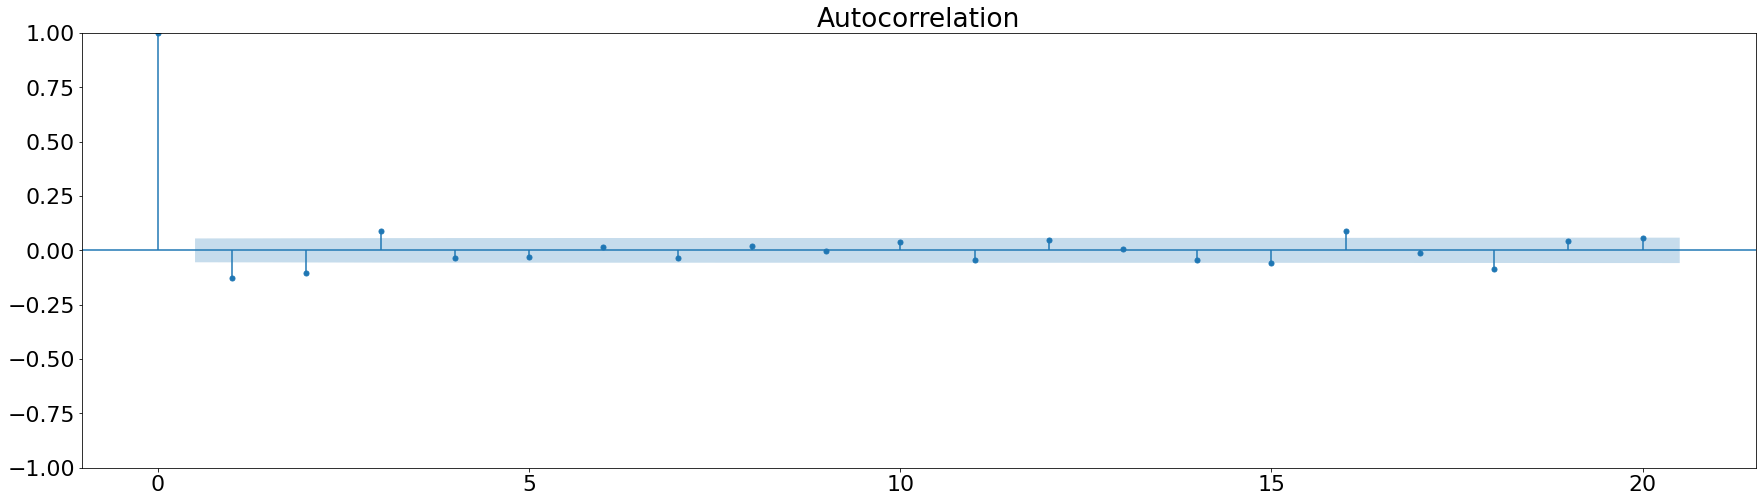

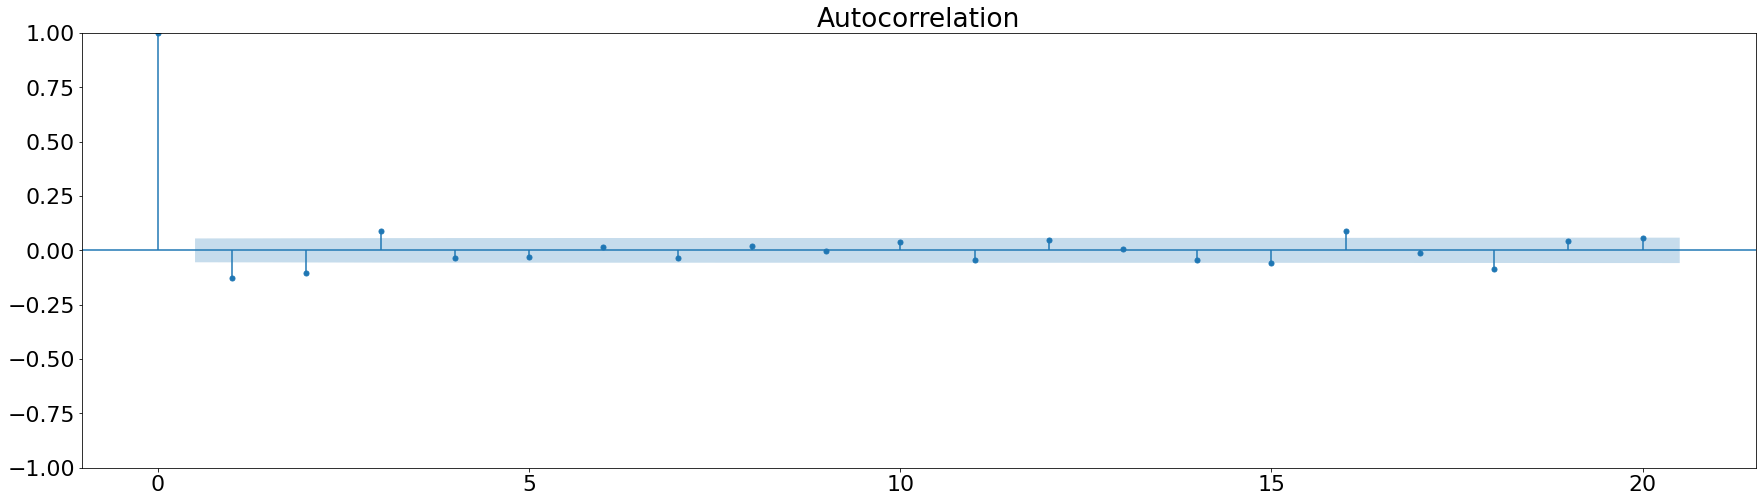

In [45]:
plot_acf(sap03['return'],lags=20)

plot shows there is little serial correlation. 

consider that the variance of return isn't constant and exhibits "volatility clustering", so will
use GARCH to model volatility;

 GARCH(1,1) is defined as:  $ \sigma_t ^2=\gamma *V_L+\alpha*u_{t-1}^2 +\beta*\sigma_{t-1}^2 \text{  }, 
\text{ } V_L \text{ is long-run average variance.} \text{     } Also, \gamma+\alpha+\beta=1, \text{and  } \omega=\gamma* V_L;$ 
$ r_t =\epsilon_t*\sigma_t\text{.  } $ $\epsilon_t$ is a random variable and has a mean of 0 and variance of 1.

Only need to estimate $\beta \text{ and } \gamma \text{, since } \alpha=1-\beta-\gamma .$\
need to maximum below likelihood summation: 
\
\
$ \large \sum\limits_{t=1}^{m}[-ln(v_t)-\frac{u_t^ 2}{v_t}] $

In [46]:
temp_col.insert(0,-99)
temp_col=temp_col[0:-1]
len(temp_col)
sap03['return_last_day']=temp_col
sap04=sap03.iloc[1:,:]
sap04.head()

,date,value,value_last_day,return,return_last_day
2,2005-07-20,1235.20,1229.35,0.004759,0.006731
3,2005-07-21,1227.04,1235.20,-0.006606,0.004759
4,2005-07-22,1233.68,1227.04,0.005411,-0.006606
5,2005-07-25,1229.03,1233.68,-0.003769,0.005411
6,2005-07-26,1231.16,1229.03,0.001733,-0.003769


In [49]:
comb=list(zip(sap04['return'].to_list(), sap04['return_last_day'].to_list()))
date_day=[x.strftime("%m/%d/%Y") for x in sap04.date.to_list()]
sap04_dict=dict(zip(date_day,comb))

#long-term variance of return series is:
VL_long=np.var(sap03['return'][0:1278])
print(round(VL_long,6))

0.000241


In [50]:
return_last_day_list=sap04['return_last_day'].to_list()

create maximum likelihood function with grid search for $\omega$ ($\omega$=$V_L$*$\gamma$) and $\beta$:

In [51]:
def likelihood_func(omega,beta,datadict):
    global volatility_list
    likelihood_list=[]
    volatility_list=[]
    var_estimate=(0.004758)**2
    gamma=omega/VL_long
    alpha=1-gamma-beta
    
    for key in datadict:
        var_estimate=omega+alpha*  ((datadict[key][1])**2)+beta*(var_estimate)
        volatility_list.append(var_estimate)
        temp_likelihood=-np.log(var_estimate)-(  (datadict[key][0])**2  )/var_estimate
        likelihood_list.append(temp_likelihood)
    return likelihood_list

In [52]:
s=[]
n1=300000
n2=100

for om in range(1,n1):
    for beta in range(1,n2):
        gamma=(om/n1/0.000241)
        if 1-gamma-beta/n2>0:
            s.append([round(om/n1,8),round(beta/n2,8),om,beta])

In [53]:
score=[]
for i in s:
    score.append([i[0],i[1],round(  sum(likelihood_func(i[0],i[1],sap04_dict)),1)])

In [54]:
score.sort(key=lambda x:x[2],reverse=True)
score[0:10]

[[3.33e-06, 0.87, 10215.5],
 [3.33e-06, 0.86, 10214.6],
 [3.33e-06, 0.88, 10214.5],
 [3.33e-06, 0.85, 10212.2],
 [3.33e-06, 0.89, 10211.4],
 [3.33e-06, 0.84, 10208.4],
 [3.33e-06, 0.9, 10205.6],
 [3.33e-06, 0.83, 10203.3],
 [3.33e-06, 0.82, 10197.2],
 [3.33e-06, 0.91, 10196.5]]

from above result, maximum likelihood 10215.5 is achieved when $\omega$=0.00000333 and $\beta$=0.87. and $\gamma$=$\omega$/$V_L$=0.00000333/0.000241=0.014.

Now check the S&P 500 index and volatility we estimated and see if they reconcile.

In [56]:
likelihood_func(0.00000333,0.87,sap04_dict)
print(' ')

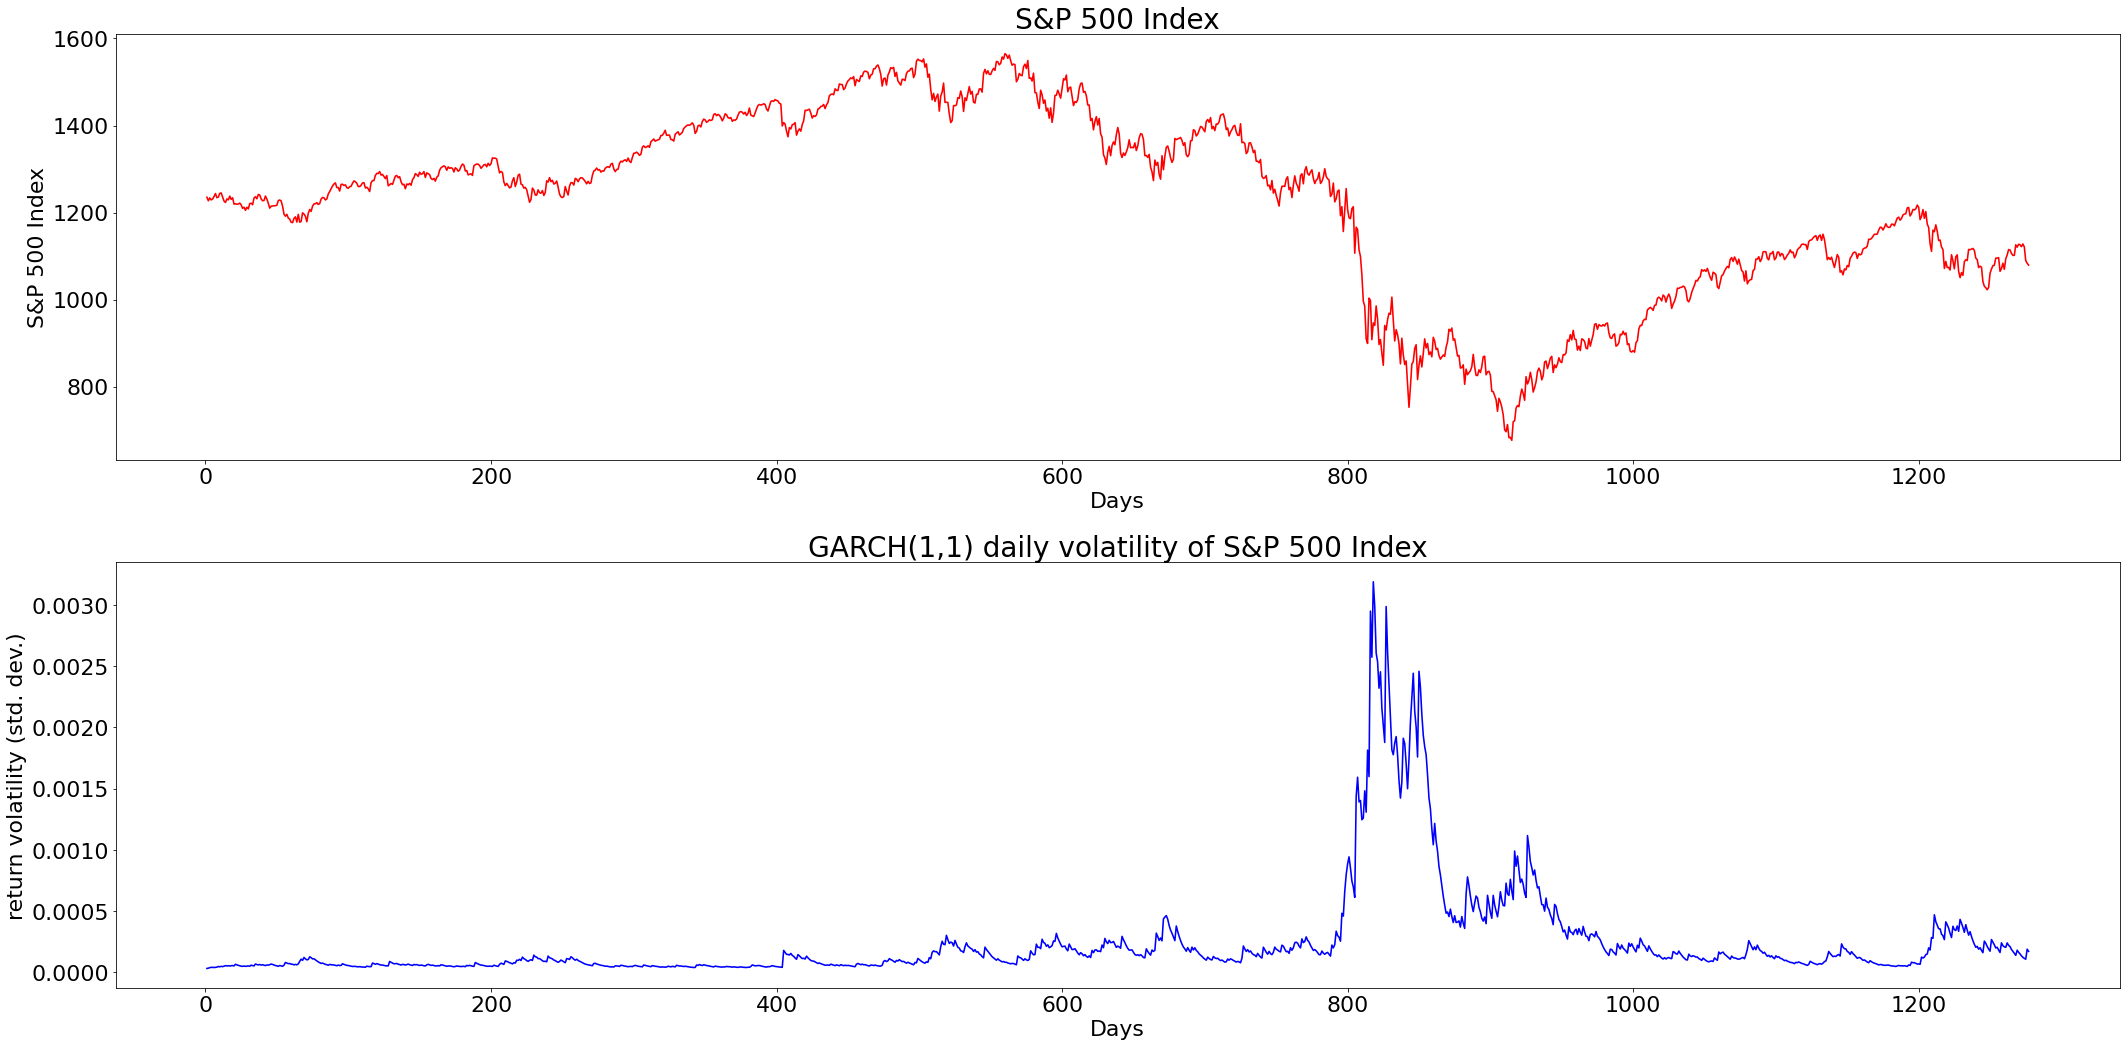

In [58]:
plt.subplot(2,1,1)
plt.plot([i for i in range(1,1278)], sap04.value.to_list(),c='red',linewidth=1.6)
figsize_tuple=(30,15)
plt.rcParams["figure.figsize"] =figsize_tuple
plt.xlabel("Days", fontsize=22)
plt.ylabel("S&P 500 Index", fontsize=22)
plt.title('S&P 500 Index',fontsize=28)

plt.subplot(2,1,2)
plt.plot([i for i in range(1,1278)], volatility_list[0:1277],c='blue',linewidth=1.6)
plt.rcParams["figure.figsize"] =figsize_tuple
plt.xlabel("Days", fontsize=22)
plt.ylabel("return volatility (std. dev.)", fontsize=22)
plt.title('GARCH(1,1) daily volatility of S&P 500 Index',fontsize=28)
plt.tight_layout()
plt.show()
plt.close()

Looks like S&P 500 index and GARCH(1,1) volatitily matches well. The index droped abruptly in Oct, 2008 (Days 818) when global markets have experienced their worst weeks since 1987. The estimated volatility reaches its peak value at same time. 
We can evaluate performance of our GARCH model by checking the autocorrelation structure for variables $\large \frac{u_t^2}{\sigma_t^2}$, if model works well, then it should remove the autocorrelation in variables $\large \frac{u_t^2}{\sigma_t^2}$.


In [59]:
# check autocorrelation before and after modelling;
return_square=[x**2 for x in sap04['return'].to_list()]
auto_corr01=sm.tsa.acf(return_square)[1:16]
auto_corr02=sm.tsa.acf(np.array(return_square)/np.array(volatility_list))[1:16]

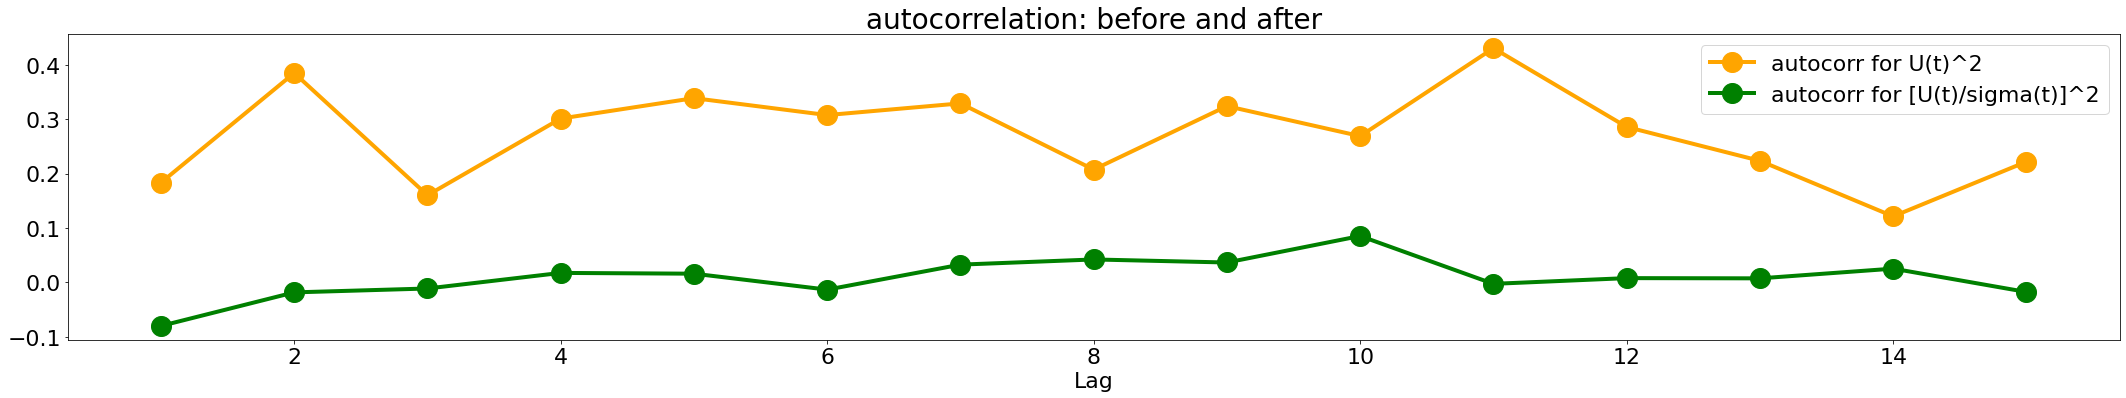

In [61]:
plt.plot([i for i in range(1,16)], auto_corr01,c='orange',linewidth=4,marker='o',markersize=20)
plt.plot([i for i in range(1,16)], auto_corr02,c='green',linewidth=4,marker='o',markersize=20)
plt.legend(['autocorr for U(t)^2','autocorr for [U(t)/sigma(t)]^2'])
plt.rcParams["figure.figsize"] =(30,6)
plt.xlabel("Lag", fontsize=22)
plt.ylabel("", fontsize=22)
plt.title('autocorrelation: before and after',fontsize=28)
plt.tight_layout()
plt.show()
plt.close()

above chart shows after using GARCH(1,1), the autocorrelations of $\large\frac{u_t^2}{\sigma_t^2}$are much smaller compared with $ u_t^2$ alone, indicating
GARCH(1,1) works well!

We now predict future volatility using GARCH model we built.\
\
since $\sigma_{n+t}^2=(1-\alpha-\beta)*V_L+\alpha*u_{n+t-1}^2+\beta*\sigma_{n+t-1}^2$\
which is same as:
$\sigma_{n+t}^2-V_L=\alpha*(u_{n+t-1}^2-V_L)+\beta*(\sigma_{n+t-1}^2-V_L)$\
take expectation of both sides and consider E($u_{n+t-1}^2)=\sigma_{n+t-1}^2 \text{  :}$\
$E(\sigma_{n+t}^2-V_L)=(\alpha+\beta)*(\sigma_{n+t-1}^2-V_L)$\
using this repeatedly:\
$E(\sigma_{n+t}^2)=V_L+(\alpha+\beta)^t*(\sigma_{n}^2-V_L)$\
since $\alpha+\beta<1$, we can see that $E(\sigma_{n+t}^2)$ is approaching V_L when t is large.
This eplains why GARCH model captures "mean reversion" of return's volatility.


for the S&P 500 data we considered, $\alpha+\beta=0.116+0.87=0.986$, expected variance rate in t days after Aug,13,2010 (last day of obs data) is: $0.000241+0.986^t*(0.000186-0.000241)$, we can plot this variance:


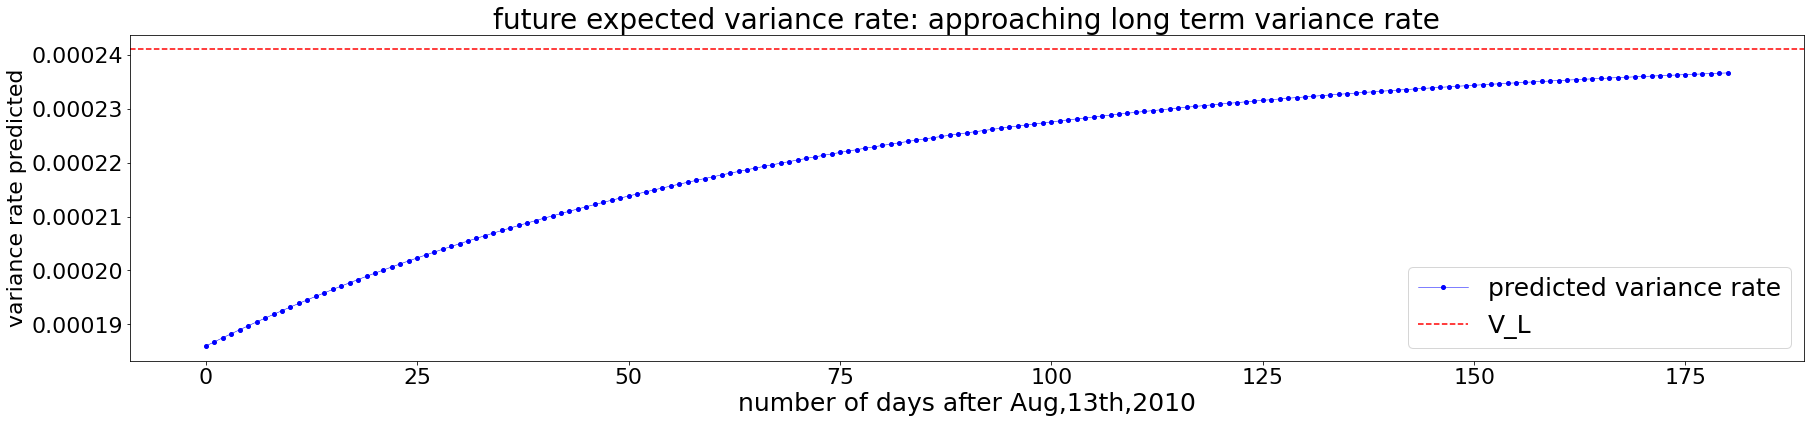

In [67]:
plt.plot([i for i in range(0,181)], [0.000241-0.000055*0.986**i for i in range(0,181)],\
         c='b',linewidth=0.5,marker='o',markersize=4)
plt.rcParams["figure.figsize"] =(30,6)
plt.xlabel("number of days after Aug,13th,2010", fontsize=25)
plt.ylabel("variance rate predicted", fontsize=22)
plt.title('future expected variance rate: approaching long term variance rate',fontsize=28)
plt.axhline(y=0.000241, color='r', linestyle='--')
plt.legend(['predicted variance rate','V_L'],fontsize='25', loc='lower right')
plt.show()
plt.close()

above chart shows variance rate exhibits mean reversion with a reversion levle at $V_L$ and reversion rate of $1-\alpha-\beta.$